# Udacity capstone project - Cancer classification using CNN's

## Project description 

#### The aim of this project to build a model that can predict if images show cancerous tissue samples are not. As you will no doubt be aware, cancer is one of the leading causes of mortality in the developed world. Simultaneously, many western societies are facing ageing populations and a shortage of medical professionals. Against this background there are clear benefits to using automated methods of processing diagnostic images - although these should be complements to - and not substitutes for - medical expertise and professional judgement.

#### This project will work with data on Invasive Ductal Carcinoma (IDC) -a form of breast cancer-  taken from the kaggle page here: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images. The data consists of images, each showing a 50 x 50 pixel region from a breast scan. I will process the data for analysis and then build a model that can distinguish cancerous sub-samples from non-cancerous ones. 

#### In this project I use a deep learning model that utilises Convolution Neural Networks (CNN's). A major advantage of working with CNN's is that they are the industry standard for computer vision and thus there are many tools predeicated on this method, with helpful documentation. Furthermore, they are designed specifically for image analysis. However, there are some alternative methods that I decided not to use. 
- One option is to use Recurrent Neural Networks, however these are more appropriate for sequences of information (i.e. there is a temporal dimension). This is why they are frequently used for tasks such as translation - where the order of the information is crucial to its meaning - and analysing videos whereas my data consists of non-sequential photos. Recurrent Neural Networks are also slower than CNN's, which could be an issue given that my final model will use a lot of data.
- Restricted Boltzman models are another option that didn't seem appropriate for this task. This approach appears to be used more for modelling systems using unsupervised learning, although I understand that they can be used for classification tasks. With the data set used in this project labels are available, allowing us to train the model with supervised learning methods, which tend to be more accurate (if interested you can see the discussion here: https://www.ibm.com/cloud/blog/supervised-vs-unsupervised-learning#:~:text=While%20supervised%20learning%20models%20tend,weather%20conditions%20and%20so%20on.)

#### In this notebook I will explore the data, prepare it for analysis and build a model. Building CNN's and tuning parameters is a process that requires logic but also some trial and error to find the model that's most appropriate to the data. As such, in this notebook I will work with a small subset of all the data available (around 1200 images). I will then run several models to find the best parameters and model architecture. I will explain my thinking to justify modifications to model hyperparameters as I go through the iterations.

### Packages


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1

from tensorflow.keras.preprocessing import image
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

### Read in data 

#### A point to note here is that the data is organised by its author in a way that makes it easier to manage computationally, however the way this has been done means that each folder ID is not unique to one patient (see this post https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/discussion/137446) . As a result, this notebook contains terms like 'pseudopatient' to reflect the fact the process being carried out would be useful when looking at individual patients, but that we cannot make inferences about individual patients based on this data.

#### The cells below does a few things, so let's break them down.

#### In our data set each pseudopatient has their own folder containing two subfolders - one with non-cancerous samples (class0) and one with cancerous samples (class1). The first loop below uses os.walk() to iterate through the folders and subfolders to create a list of all the file names - called image_paths.

#### The second loop goes through all of the filenames in image_path and for each one reads in the corresponding image file and saves it in a list called 'images'

In [2]:
root_dir = 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder'
image_paths = []
images = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        image_paths.append(full_path)

In [3]:
for image_path in image_paths:
    try:
        img = Image.open(image_path)
        images.append(img)
    except IOError:
        print(f"Error: Could not read image {image_path}")

In [137]:
#images

In [5]:
len(images)

1249

In [138]:
#image_paths

In [7]:
len(image_paths)

1249

### Preparing the data

#### In this section we will:
- Check if the dimensions of the images are consistent and either resize or drop images as necessary.
- Create our classes data


#### Lets's check out the first image in the dataset as an example

In [8]:
example_image = images[0]

height = example_image.height
width = example_image.width

print('image height and width:', height, width) # looks good

image height and width: 50 50


#### Now let's analyse all of the images. Note that the values returned are the index values for the images with dimensions other than 50 x 50. We can use this to see how many images deviate from the 50x50 dimensions.


In [9]:
heights_list = []
widths_list = []

for img in images:
    heights_list.append(img.height)
    widths_list.append(img.width)

deviant_heights = [index for (index, item) in enumerate(heights_list) if item != 50]

print(deviant_heights)

[325]


#### By uncommenting 'images' above and scroling through the list we can see there is one image that has dimensions 50 x 1. This is possibly an error in data generation as the image is only one pixel tall. Now let's check the widths.

In [10]:
deviant_widths = [index for (index, item) in enumerate(widths_list) if item != 50]

print(deviant_widths)

[744, 745, 746]


#### Scrolling through the images list again these three images have dimensions 42x50 so are likely still useful.

#### At this point we want to remove the 50 x 1 and resize the 42 x 50 images. However, thinking ahead if we remove the 50 x 1 image without removing it's corresponding file path in the image_paths list then this will lead to the images and classes data sets being inconsistent with each other. Let's remove the image path corresponding to the 50 x 1 image

In [11]:
# Create a dictionary mapping images to file paths
image_file_dict = dict(zip(map(str, images), image_paths))

# Remove images from the data set
filtered_images = [img for img in images if img.height >= 40]

# Remove the corresponding file paths from the file_paths list
filtered_paths = [image_file_dict[str(image)] for image in filtered_images]


In [12]:
len(filtered_images)

1248

In [13]:
len(filtered_paths)

1248

#### Now to resize the remaining images

In [14]:
resized_images = []

for img in filtered_images:
    resz = img.resize((50, 50))
    resized_images.append(resz)

In [15]:
len(resized_images)

1248

#### We can repeat the process above to see if we have any images that aren't 50 x50

In [16]:
heights_list = []
widths_list = []

for img in resized_images:
    heights_list.append(img.height)
    widths_list.append(img.width)

deviant_heights = [index for (index, item) in enumerate(heights_list) if item != 50]

print(deviant_heights)

[]


In [17]:
deviant_widths = [index for (index, item) in enumerate(widths_list) if item != 50]

print(deviant_widths)

[]


#### Great! Now we're ready to create the classes data which will provide our labels in the CNN model.

#### For each image we want to know the class; 0 for non-cancerous or 1 for cancerous. As this information is in the file names, we can get this by iterating through the strings in the file names and extracting the fifth-from-last digit. The data is then saved in a list called 'classes'

In [18]:
classes = []

for name in filtered_paths:
    diagnosis = name[-5]
    classes.append(diagnosis)

In [20]:
len(classes)

1248

### Understanding the data

#### Now let's try to understand the data a bit better. In this section I will:
- Compare the number of cancerous and non-cancerous samples in our data set and check the data is a balanced.
- See if the number of samples is consistent across pseudopatients. If this code ever gets applied to data with individual patient ID's then this would be a nice check to include.
- Actually look at the images we have to get an idea of distinguishes cancerous and non-cancerous samples

#### To see if the labels data is balanced, I will make the classes variable into a pandas dataframe and use the value_counts method.

In [21]:
diagnosis_df= pd.DataFrame({'class': classes})

In [22]:
diagnosis_df.head()

,class
0,0
1,0
2,0
3,0
4,0


In [23]:
len(diagnosis_df)

1248

<AxesSubplot:xlabel='class'>

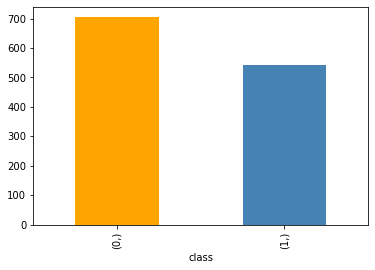

In [24]:
colors = ['orange', 'steelblue']
diagnosis_df.value_counts().plot(kind='bar', color=colors)

In [25]:
diagnosis_df.value_counts()

class
0        704
1        544
dtype: int64

#### In our data we have a small majority of non-cancerous samples, though this looks like there are enough observations in each class for a model to be trained on the data. Now as a quick QA, let's see if the number of samples is similar for each 'patient'. Given the previous discussion about how each ID doesn't reflect a unique patient in this data set we don't need to worry if there is an imbalance, but in reality this could provide a useful check that health practitioners have carried out the data generating process correctly.

#### Originally I intended to extract ID numbers from the file names using slicing again. However the file names are of different lengths, meaning that using regular expressions was a better approach here

In [26]:
pattern = r"\\(\d+)_"
id = []

for name in image_paths:
    match = re.search(pattern, name)
    if match:
        id_number = match.group(1)
        id.append(id_number)


In [28]:
id = pd.DataFrame({'id_no': id})

In [29]:
id

,id_no
0,12241
1,12241
2,12241
3,12241
4,12241
...,...
1244,12242
1245,12242
1246,12242
1247,12242


In [30]:
id.value_counts()

id_no
12242    1097
12241     152
dtype: int64

#### To get an idea of what kind of images we're dealing with, let's plot a few. Below we have 4 non-cancerous samples and 4 cancerous ones. At a glance there are some differences - for example the cancerous samples tend to have denser blocks of darker pixels, whereas the non-cancerous ones tend to have swirls or abstract patterns to them. However, looking at the right-most non-cancerous sample, this has some characteristics of a cancerous sample. For a experienced professional it might be possible to reliably distinguish between the classes by looking at the images, though I doubt many other people could.

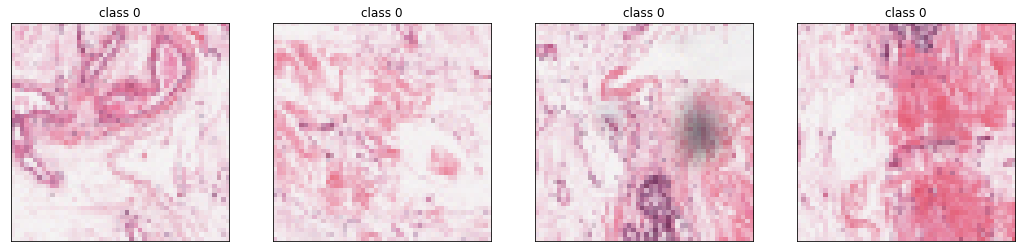

In [31]:
fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

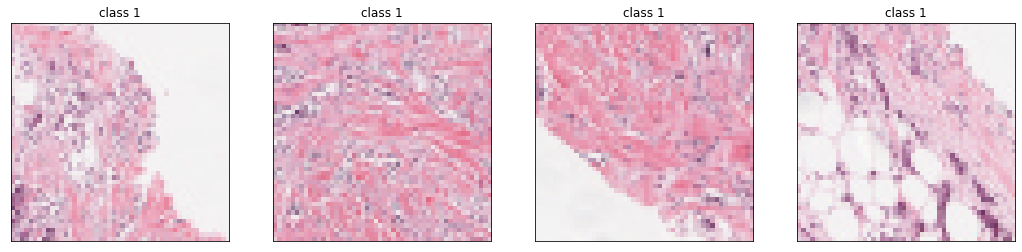

In [32]:
fig = plt.figure(figsize=(18,18))
for i in range(51, 55):
    ax = fig.add_subplot(1, 4, i - 50, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

## Modelling

#### In this section I will:
- Perform some final checks on my data
- Create my training and test data sets
- Run a simple model which I will then refine to find the best performing interation of the model

#### Both inputs need to be defined as np arrays

In [33]:
classes = np.array(classes)
classes= classes.astype(int)

In [34]:
image_data = np.array([image.img_to_array(img) for img in resized_images])

In [35]:
type(classes)

numpy.ndarray

In [36]:
classes

array([0, 0, 0, ..., 1, 1, 1])

In [37]:
classes.dtype

dtype('int32')

In [38]:
np.unique(classes)

array([0, 1])

In [39]:
# Vanishing gradients need to be considered

#### Create training, validation and test datasets. Note that I am using train_test_split twice here. Once to create the train and test data, then a second time to allocate some of the training data to a validation set that can be used to monitor how well the model generalises to unseen data in each training epoch. I have used the random_state parameter to ensure the same images are allocated to each dataset whenever this code is run.

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split (image_data, classes, test_size = 0.3, random_state=101)

In [41]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=101)

In [42]:
len(image_data)

1248

In [43]:
len(X_test)

375

In [44]:
len(X_train)

698

In [45]:
len(X_val)

175

In [46]:
len(Y_train)

698

In [47]:
len(Y_test)

375

In [48]:
len(Y_val)

175

In [49]:
X_shape = X_train.shape

#### Build model - below is about the most basic model that can be used for this problem. Maybe its also the most appropriate, but that needs to be tested.

#### A note on some of the hyperparameters chosen. A heuristic that I came across for size of the filter in the convolutional layer is that if you think model needs to learn small details then you need smaller filters. However if identifying broader features will do the trick then can use a larger filter. In this case the images are relatively low res, plus the difference  between a cancerous and non-cancerous sample seems to be a matter of broad patterns, thus I have selected a relatively large window size.
#### I've also started with 16 filters as these should cover most basic shapes and blob detection, however I will experiment with this hyperparameter later.

In [50]:
model = Sequential()
model.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same', 
                 activation = 'relu')) 
model.add(MaxPool2D (pool_size = 2,
                    strides = (2,2),
                    padding = 'same'))
model.add(Flatten())
model.add(Dense(250, activation = 'relu', input_shape = X_shape))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

#### Compiling the model
#### I have selected binary cross entropy as this is the appropriate loss function for binary classification tasks. 'Adam' is a decent all-purpose optimizer so worth trying initially. It is possible to have sparse data from our images so can then compare to using rmsprop, which is well suited to such data

In [51]:
model.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )

#### Fit model

In [52]:
model.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val))

Epoch 1/50
22/22 [==============================] - 1s 22ms/step - loss: 41.2213 - accuracy: 0.5401 - val_loss: 2.3884 - val_accuracy: 0.5371
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 1.2642 - accuracy: 0.5415 - val_loss: 0.6815 - val_accuracy: 0.5486
Epoch 3/50
22/22 [==============================] - 0s 12ms/step - loss: 0.7269 - accuracy: 0.5516 - val_loss: 0.6482 - val_accuracy: 0.6000
Epoch 4/50
22/22 [==============================] - 0s 12ms/step - loss: 0.6810 - accuracy: 0.5874 - val_loss: 0.6320 - val_accuracy: 0.6286
Epoch 5/50
22/22 [==============================] - 0s 12ms/step - loss: 0.6294 - accuracy: 0.6203 - val_loss: 0.5908 - val_accuracy: 0.6629
Epoch 6/50
22/22 [==============================] - 0s 13ms/step - loss: 0.5994 - accuracy: 0.6289 - val_loss: 0.6148 - val_accuracy: 0.6629
Epoch 7/50
22/22 [==============================] - 0s 12ms/step - loss: 0.5839 - accuracy: 0.6461 - val_loss: 0.6275 - val_accuracy: 0.6286
Epoch 8/50
2

#### Below I have plotted out metric for model performance in each epoch of training. In the top diagram we have the training loss and validation loss for each epoch. Below that is a similar figure for accuracy.

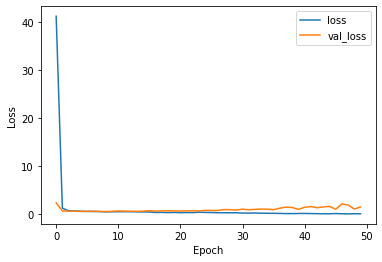

In [53]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

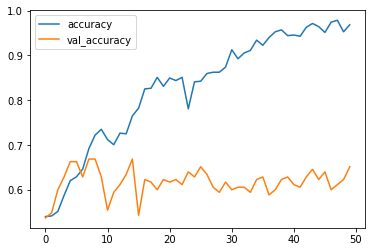

In [54]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
plt.show()

In [55]:
score_1 = model.evaluate(X_test, Y_test, verbose = 0)
print(score_1[1])

0.7066666483879089


#### The accuracy score is decent ,however for use in a clincal setting we would want something higher than this. Furthermore the behaviour of the loss and validation loss aren't ideal. Really we would want to see them both track downwards with each epoch, showing that the model is learning. Instead the loss crashes then stagnates, while the validation loss actually rises towards the end of training. This suggests that the model is not learning well and may be using noise / irrelevant features to predict values. Below I explore some ways of trying to improve the models performance.

## Improving the model

#### So far we have a model, but it isn't an awful lot better than a coin flip. In this section look at two ways to improve the accuracy of the model:
- 1) Add variation (and hence information) to our data set using data augmentation
- 2) Play around with various parameters in the architecture and see if this improves performance
 

### Data augmentation

#### Let's look at doing data augmentation then adjusting the model hyperparameters. Data Augmentation is a process where the image data has things done to it like zooming in/out, random rotations or random flips. The idea is to create more variation in the data, thus creating learning opportunities for the model. I'd like to note that I use a different approach to that shown in the course. Official tensorflow documentation (see link below) states that ImageDataGenerator is not recommended for new code, and that instead preprocessing layers are recommended.  
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

#### I have followed the preprocessing layers approach, and found the documentation below pretty helpful
- https://www.tensorflow.org/tutorials/images/data_augmentation

#### This site gives a useful list of the different layers available - including the augmentations that you can do:
- https://www.tensorflow.org/api_docs/python/tf/keras/layers

#### In the cell below I define the manipulations that I want done on the images. Here I have chosen to start simple and use random horizontal and vertical flips, as well as rescaling.

In [56]:
# This function takes in an 1 x n array of images and applies random flips and rescaling to them.
# The output from this function is a 1 x n array of augmented images

augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed= 1),
layers.Rescaling( 1/255)])

#### Let's apply the augmentation to each image in turn and save the new image in the 'augmented_images' variable

In [57]:
augmented_images = []
for image in resized_images:
    augmented_image = augmentation(image)
    augmented_images.append(augmented_image)

In [59]:
type(augmented_images)

list

#### The augmented_images data is effectively a set of tensors, meaning that we can pass this to a CNN model. However, it would be nice to see what has been done to the images and compare them to the original images. To do this we need to turn the convert our arrays in 'augmented_images' back into image files.

In [60]:
# Convert augmented images back to numpy array if needed
augmented_array = [x.numpy() for x in augmented_images]

In [62]:
type(augmented_array)

list

In [63]:
# Convert back into an image
converted_images = []

for img in augmented_array:

 image = tf.keras.preprocessing.image.array_to_img(img) 
 converted_images.append(image)

In [65]:
type(converted_images)

list

#### Now we can visualise both sets of images!

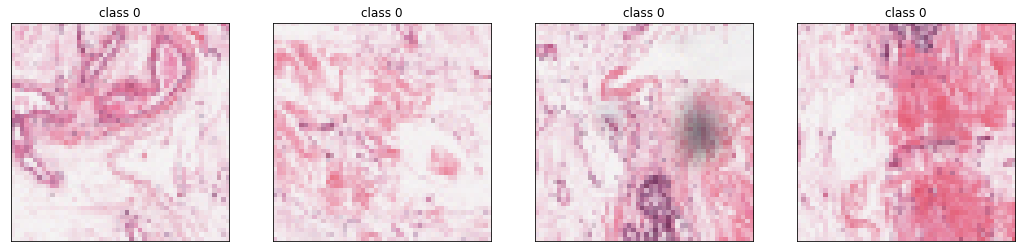

In [66]:
#Plot original images
fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

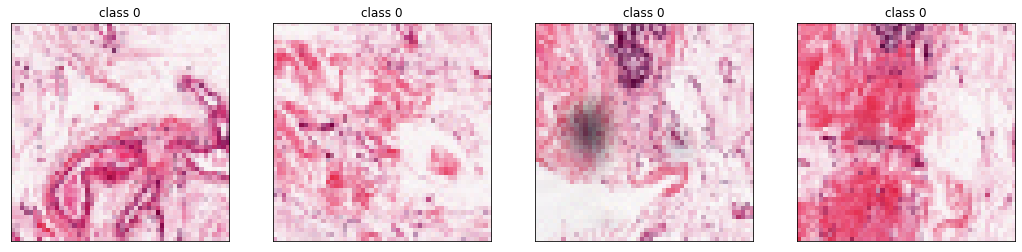

In [67]:
# Note that the augmentation process can drastically alter the pixel values, so need to normalise images

#Plot the augmented versions of the images above
fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    #normalized_image = exposure.rescale_intensity(augmented_images[i], out_range=(0, 1))
    ax.imshow(converted_images[i])
    ax.set_title('class {}'.format(classes[i]))

#### Above we can see our orignal images (top) and the augmented images (below). The augmented images are recognisable as the originals but flipped. The new images also have a sharper contrast between the lighter and darker regions of the image - possibly due to the rescaling. Now it's time to use this data in a model!

#### Define training and test data, input shape and double check data is in np.array format

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split (augmented_images, classes, test_size = 0.3, random_state=101)

In [69]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state= 101)

In [70]:
X_train = np.array(X_train)

In [71]:
X_train.shape

(698, 50, 50, 3)

In [72]:
X_Shape = X_train.shape

In [73]:
type(X_train)

numpy.ndarray

#### As a a quick QA of the training data, let's see if the labels are reasonably balanced within the training data.

In [74]:
QA_train = pd.DataFrame(Y_train)

In [75]:
QA_train.value_counts()

0    394
1    304
dtype: int64

#### Around 43% of observations are in class 1. This is likely to be balanced enough.

In [76]:
X_test=np.array(X_test)

In [77]:
X_test.shape

(375, 50, 50, 3)

In [78]:
X_val = np.array(X_val)

In [79]:
X_val.shape

(175, 50, 50, 3)

#### Try out models using the augmented data

In [80]:
model2 = Sequential()
model2.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model2.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model2.add(Flatten())
model2.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation = 'sigmoid'))

In [81]:
model2.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model2.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val))

Epoch 1/50
22/22 [==============================] - 1s 20ms/step - loss: 0.8717 - accuracy: 0.5244 - val_loss: 0.6859 - val_accuracy: 0.5371
Epoch 2/50
22/22 [==============================] - 0s 11ms/step - loss: 0.6732 - accuracy: 0.5602 - val_loss: 0.6869 - val_accuracy: 0.5371
Epoch 3/50
22/22 [==============================] - 0s 11ms/step - loss: 0.6780 - accuracy: 0.6060 - val_loss: 0.6737 - val_accuracy: 0.5371
Epoch 4/50
22/22 [==============================] - 0s 11ms/step - loss: 0.6632 - accuracy: 0.5788 - val_loss: 0.6739 - val_accuracy: 0.5371
Epoch 5/50
22/22 [==============================] - 0s 11ms/step - loss: 0.6830 - accuracy: 0.5688 - val_loss: 0.7016 - val_accuracy: 0.5371
Epoch 6/50
22/22 [==============================] - 0s 11ms/step - loss: 0.6447 - accuracy: 0.5731 - val_loss: 0.6389 - val_accuracy: 0.5086
Epoch 7/50
22/22 [==============================] - 0s 11ms/step - loss: 0.6445 - accuracy: 0.5931 - val_loss: 0.6359 - val_accuracy: 0.6343
Epoch 8/50
22

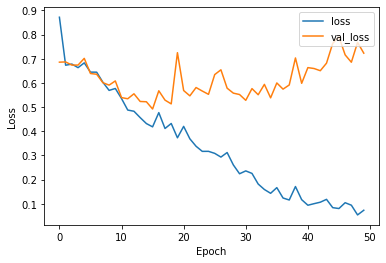

In [82]:
plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

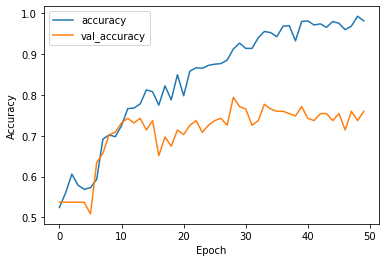

In [83]:
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [84]:
aug_score2  = model2.evaluate(X_test, Y_test, verbose = 0)
print(aug_score2[1])

0.7440000176429749


#### This is clearly an improvement in the behaviour of the model over the course of training, with the loss showing more a a downward trend - although the performance on the validation data plateaus quite early on. The performance on the test data is similar to model 1, though slightly better.

#### Here we want to build up the architecture a bit further by adding the second conv2d layer

In [93]:
model3 = Sequential()
model3.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model3.add(Conv2D(filters = 16,  
                 kernel_size = 3, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model3.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model3.add(Flatten())
model3.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation = 'sigmoid'))

In [94]:
model3.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model3.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 1s 29ms/step - loss: 0.7237 - accuracy: 0.5415 - val_loss: 0.6902 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 17ms/step - loss: 0.6774 - accuracy: 0.5716 - val_loss: 0.7061 - val_accuracy: 0.5371
Epoch 3/50
14/14 [==============================] - 0s 17ms/step - loss: 0.6788 - accuracy: 0.5645 - val_loss: 0.6969 - val_accuracy: 0.5371
Epoch 4/50
14/14 [==============================] - 0s 17ms/step - loss: 0.6524 - accuracy: 0.5616 - val_loss: 0.6666 - val_accuracy: 0.5543
Epoch 5/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6296 - accuracy: 0.6246 - val_loss: 0.6601 - val_accuracy: 0.5886
Epoch 6/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6486 - accuracy: 0.5946 - val_loss: 0.6738 - val_accuracy: 0.5029
Epoch 7/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6115 - accuracy: 0.6547 - val_loss: 0.6418 - val_accuracy: 0.6686
Epoch 8/50
14

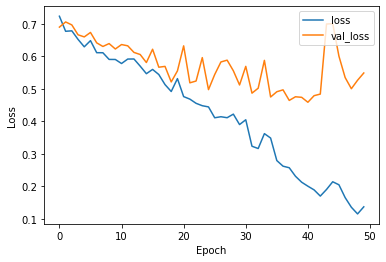

In [95]:
plt.plot(model3.history.history['loss'])
plt.plot(model3.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

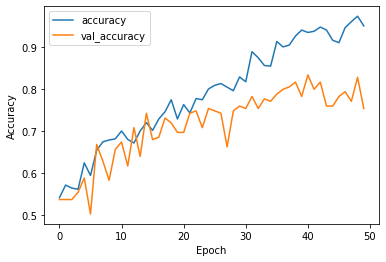

In [96]:
plt.plot(model3.history.history['accuracy'])
plt.plot(model3.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [97]:
aug_score3 = model3.evaluate(X_test, Y_test, verbose = 0)
print(aug_score3[1])

0.7519999742507935


####  This is a slight improvement on model 2.
#### Let's add a second Max Pooling layer and see if this further improves the results obtained

In [99]:
model4 = Sequential()
model4.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model4.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model4.add(Conv2D(filters = 16,  
                 kernel_size = 3, #note that the map here is smaller than above 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model4.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model4.add(Flatten())
model4.add(Dense(250, activation = 'relu', input_shape = X_Shape))
model4.add(Dropout(0.3))
model4.add(Dense(1, activation = 'sigmoid'))

In [100]:
model4.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model4.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=50)

Epoch 1/50
14/14 [==============================] - 1s 29ms/step - loss: 0.6794 - accuracy: 0.5616 - val_loss: 0.6811 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 17ms/step - loss: 0.6704 - accuracy: 0.5659 - val_loss: 0.6736 - val_accuracy: 0.5371
Epoch 3/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6542 - accuracy: 0.5659 - val_loss: 0.6666 - val_accuracy: 0.5371
Epoch 4/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6424 - accuracy: 0.5874 - val_loss: 0.7534 - val_accuracy: 0.5371
Epoch 5/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6476 - accuracy: 0.6203 - val_loss: 0.6650 - val_accuracy: 0.5257
Epoch 6/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6058 - accuracy: 0.6504 - val_loss: 0.6325 - val_accuracy: 0.5771
Epoch 7/50
14/14 [==============================] - 0s 16ms/step - loss: 0.5972 - accuracy: 0.7034 - val_loss: 0.6110 - val_accuracy: 0.6686
Epoch 8/50
14

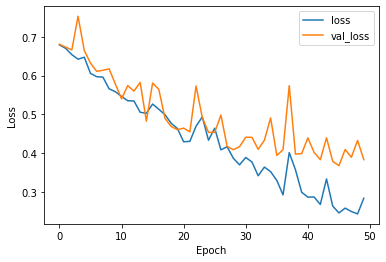

In [101]:
plt.plot(model4.history.history['loss'])
plt.plot(model4.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

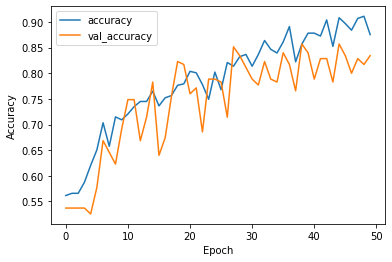

In [102]:
plt.plot(model4.history.history['accuracy'])
plt.plot(model4.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [103]:
aug_score4 = model4.evaluate(X_test, Y_test, verbose = 0)
print(aug_score4[1])

0.7760000228881836


#### We have a decent architecture above, but let's see if we can imporve on it by tuning the hyperparameters by using cross validation

#### Note that because we re passing a keras model to an sklearn function, there are a few extra steps, otherwise the model will not implement a 'get_params' function and will thus be incompatible with GridSearchCV. As a result we use a keras wrapper.



In [106]:
parameters = {
    'conv1_filters': [8, 16],
    'conv1_kernel_size': [3, 5],
    'conv2_filters': [8, 16],
    'conv2_kernel_size': [3, 5],
    'batch_size' : [None, 25, 50]
}

In [107]:
def create_model(conv1_filters, conv1_kernel_size, conv2_filters, conv2_kernel_size):

 model6 = Sequential()
 model6.add(Conv2D(filters= conv1_filters,  
                 kernel_size= conv1_kernel_size, 
                 strides=(2, 2), 
                 padding='same',
                 activation='relu',
                 name='conv1'))
 model6.add(MaxPool2D(pool_size=2, 
                    strides=(2, 2),
                    padding= 'same',
                    name='maxpool1'))
 model6.add(Conv2D(filters=conv2_filters,  
                 kernel_size=conv2_kernel_size, 
                 strides=(2, 2), 
                 padding= 'same',
                 activation='relu',
                 name='conv2'))
 model6.add(MaxPool2D(pool_size=2, 
                    strides=(2, 2),
                    padding='same',
                    name='maxpool2'))
 model6.add(Flatten())
 model6.add(Dense(250, activation='relu', name='dense1'))
 model6.add(Dropout(0.3))
 model6.add(Dense(1, activation='sigmoid', name='dense2'))
 model6.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
 return model6

In [108]:
model_cv = KerasClassifier(build_fn=create_model)

C:\Users\Laurence\AppData\Local\Temp\ipykernel_928\4290163951.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_cv = KerasClassifier(build_fn=create_model)


In [109]:
Grid = GridSearchCV(estimator= model_cv, param_grid = parameters, n_jobs=-1, scoring ='accuracy')

In [110]:
Grid.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val))

Epoch 1/50
14/14 [==============================] - 2s 56ms/step - loss: 0.6830 - accuracy: 0.5544 - val_loss: 0.6810 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6696 - accuracy: 0.5602 - val_loss: 0.6718 - val_accuracy: 0.5314
Epoch 3/50
14/14 [==============================] - 0s 17ms/step - loss: 0.6550 - accuracy: 0.5788 - val_loss: 0.6577 - val_accuracy: 0.6229
Epoch 4/50
14/14 [==============================] - 0s 16ms/step - loss: 0.6324 - accuracy: 0.6232 - val_loss: 0.6573 - val_accuracy: 0.5943
Epoch 5/50
14/14 [==============================] - 0s 15ms/step - loss: 0.6153 - accuracy: 0.6504 - val_loss: 0.6303 - val_accuracy: 0.6629
Epoch 6/50
14/14 [==============================] - 0s 16ms/step - loss: 0.5844 - accuracy: 0.7149 - val_loss: 0.5949 - val_accuracy: 0.7029
Epoch 7/50
14/14 [==============================] - 0s 13ms/step - loss: 0.5513 - accuracy: 0.7536 - val_loss: 0.5602 - val_accuracy: 0.6800
Epoch 8/50
14

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000022A69128AC0>,
             n_jobs=-1,
             param_grid={'batch_size': [None, 25, 50], 'conv1_filters': [8, 16],
                         'conv1_kernel_size': [3, 5], 'conv2_filters': [8, 16],
                         'conv2_kernel_size': [3, 5]},
             scoring='accuracy')

In [112]:
Grid.best_params_

{'batch_size': 50,
 'conv1_filters': 16,
 'conv1_kernel_size': 3,
 'conv2_filters': 16,
 'conv2_kernel_size': 3}

In [132]:
Grid_preds = Grid.predict(X_test)
Grid_preds[Grid_preds<0.5]=0
Grid_preds[Grid_preds>=0.5]= 1

12/12 [==============================] - 0s 5ms/step


In [133]:
Grid_accuracy = accuracy_score(Y_test, Grid_preds)

In [134]:
Grid_accuracy

0.7946666666666666

In [113]:
accuracy = Grid.cv_results_['mean_test_score']

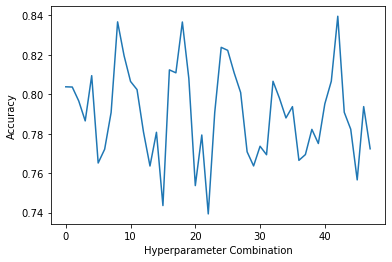

In [114]:
# Plotting the accuracy and loss
plt.plot(accuracy)
#plt.plot(loss)
#plt.legend(['accuracy', 'loss'], loc='upper right')
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Accuracy')
plt.show()

#### The code above doesn't return a history of the accuracy scores across epochs in the way that a normal keras model does.

#### Below I run the model again with the best params returned, so that I can incorporate the best batch_size, plot the accuracy and loss history and use regularisation to ensure the tuned model is not overfitting to the training data

In [116]:
model5 = Sequential()
model5.add(Conv2D(filters=Grid.best_params_['conv1_filters'],  
                 kernel_size= Grid.best_params_['conv1_kernel_size'], 
                 strides=(2, 2), 
                 padding='same',
                 activation='relu',
                 name='conv1'))
model5.add(MaxPool2D(pool_size=2, 
                    strides=(2, 2),
                    padding= 'same',
                    name='maxpool1'))
model5.add(Conv2D(filters= Grid.best_params_['conv2_filters'],  
                 kernel_size= Grid.best_params_['conv2_kernel_size'], 
                 strides=(2, 2), 
                 padding= 'same',
                 activation='relu',
                 name='conv2'))
model5.add(MaxPool2D(pool_size=2, 
                    strides=(2, 2),
                    padding= 'same',
                    name='maxpool2'))
model5.add(Flatten())
model5.add(Dense(250, activation='relu', name='dense1', kernel_regularizer=l1(0.0015)))
model5.add(Dropout(0.3))
model5.add(Dense(1, activation='sigmoid', name='dense2'))

In [117]:
model5.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model5.fit(X_train, Y_train, epochs = 50, validation_data=(X_val, Y_val), batch_size=Grid.best_params_['batch_size'])

Epoch 1/50
14/14 [==============================] - 1s 29ms/step - loss: 5.3240 - accuracy: 0.5444 - val_loss: 4.7009 - val_accuracy: 0.5371
Epoch 2/50
14/14 [==============================] - 0s 13ms/step - loss: 4.2001 - accuracy: 0.5630 - val_loss: 3.6711 - val_accuracy: 0.5371
Epoch 3/50
14/14 [==============================] - 0s 13ms/step - loss: 3.2411 - accuracy: 0.5645 - val_loss: 2.7915 - val_accuracy: 0.5371
Epoch 4/50
14/14 [==============================] - 0s 12ms/step - loss: 2.4327 - accuracy: 0.5602 - val_loss: 2.0785 - val_accuracy: 0.5371
Epoch 5/50
14/14 [==============================] - 0s 13ms/step - loss: 1.7883 - accuracy: 0.5587 - val_loss: 1.5119 - val_accuracy: 0.5143
Epoch 6/50
14/14 [==============================] - 0s 14ms/step - loss: 1.3024 - accuracy: 0.5831 - val_loss: 1.1142 - val_accuracy: 0.4857
Epoch 7/50
14/14 [==============================] - 0s 13ms/step - loss: 0.9714 - accuracy: 0.5745 - val_loss: 0.8661 - val_accuracy: 0.6686
Epoch 8/50
14

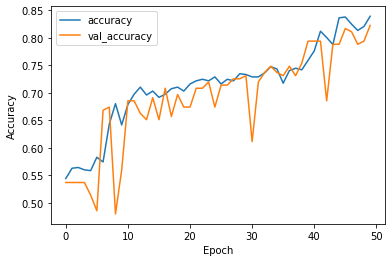

In [118]:
plt.plot(model5.history.history['accuracy'])
plt.plot(model5.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

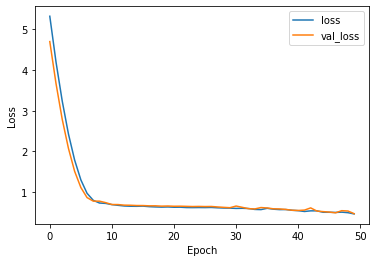

In [119]:
plt.plot(model5.history.history['loss'])
plt.plot(model5.history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [120]:
score5 = model5.evaluate(X_test, Y_test, verbose = 0)
print(score5[1])

0.8266666531562805


In [130]:
results_list = [score_1[1], aug_score2[1], aug_score3[1] , aug_score4[1], Grid_accuracy, score5[1]]

names_list = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

descriptions_list = ['Baseline model', 'Baseline model with augmented data', 'Extra convolutional layer', 'Extra Max Pooling layer', 'Model 5 with tuned hyperparameters', 'Tuned model with regularisation']

Results = pd.DataFrame(list(zip(names_list, descriptions_list, results_list)), columns=['Model', 'Description', 'Accuracy Score'])

In [131]:
Results

,Model,Description,Accuracy Score
0,Model 1,Baseline model,0.706667
1,Model 2,Baseline model with augmented data,0.744000
2,Model 3,Extra convolutional layer,0.752000
3,Model 4,Extra Max Pooling layer,0.776000
4,Model 5,Model 5 with tuned hyperparameters,0.794667
5,Model 6,Tuned model with regularisation,0.826667


In [135]:
preds = model5.predict(X_test)
preds[preds<0.5]=0
preds[preds>=0.5]= 1
f1_score(Y_test, preds)

12/12 [==============================] - 0s 4ms/step


0.7854785478547854

### Evaluation and Summary

#### In the previous section we've seen a lot of variations on a simple CNN model. We've augmented our data and experimented with several different architectures. We've indirectly experiemtned with hyperparameters - albeit GridSearchCV has done this on our behalf. 

#### Let's look at the performance of the different iterations of the model.

In [136]:
Results

,Model,Description,Accuracy Score
0,Model 1,Baseline model,0.706667
1,Model 2,Baseline model with augmented data,0.744000
2,Model 3,Extra convolutional layer,0.752000
3,Model 4,Extra Max Pooling layer,0.776000
4,Model 5,Model 5 with tuned hyperparameters,0.794667
5,Model 6,Tuned model with regularisation,0.826667


#### As we can see, the performance of the model has improved with each iteration of the model. By augmenting our data we were able to increase the amount of information contained in the dat set. Then by adding more convolutional and max pooling layers we were able to extract more of this information from the images. By using cross-validation and regularisation we were able to obtain the best hyperparameters for this model, but without overfitting to the training data, meaning that in the final iteration of the model it was possible to achieve an accuracy rate of 83% when attempting to predict the values in the test data.

#### If we compare the performance of model 7 to some of other decent models, we can see that the validation loss / accuracy is nowhere near as volatile as for model 8, while it plateaus maybe 10 epochs later than model 6.

#### Personally I am quite happy with model 6. It has an accuracy score of 0.83, meaning that it was able to predict 83% of labels in the test data correctly. In terms of application of the model, a quick googling brought up this article evaluating the performance of existing AI tools used to identify certain cancers.

https://www.frontiersin.org/articles/10.3389/fmed.2022.1018937/full#:~:text=The%20sensitivity%20and%20specificity%20of,99.1)%20(Supplementary%20Figures).

#### Although they look at sensitivity and specificity (and thus the ability to avoid false negative and false positives) rather than accuracy, the typical percentage scores they find are somewhere between the high 80's and low 90's. The result for model 6 is not far off of this, suggesting that if I were to apply it to the full data set the result might be clinically useful.
